# The data

In [50]:
import pandas as pd
import numpy as np

col_names = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age', 'label']
# Load dataset
pima = pd.read_csv("diabetes.csv", header=None, names=col_names)

# Take a preview
pima.head()

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,label
0,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
1,6,148,72,35,0,33.6,0.627,50,1
2,1,85,66,29,0,26.6,0.351,31,0
3,8,183,64,0,0,23.3,0.672,32,1
4,1,89,66,23,94,28.1,0.167,21,0


# Data exploration

In [51]:
pima.isna().sum()
pima = pima.drop(0)

pima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 1 to 768
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   pregnant  768 non-null    object
 1   glucose   768 non-null    object
 2   bp        768 non-null    object
 3   skin      768 non-null    object
 4   insulin   768 non-null    object
 5   bmi       768 non-null    object
 6   pedigree  768 non-null    object
 7   age       768 non-null    object
 8   label     768 non-null    object
dtypes: object(9)
memory usage: 54.1+ KB


In [52]:
#Adjust data types
pima[col_names] = pima[col_names].apply(pd.to_numeric, errors='coerce')
pima.describe()

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,label
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


# Data preprocessing

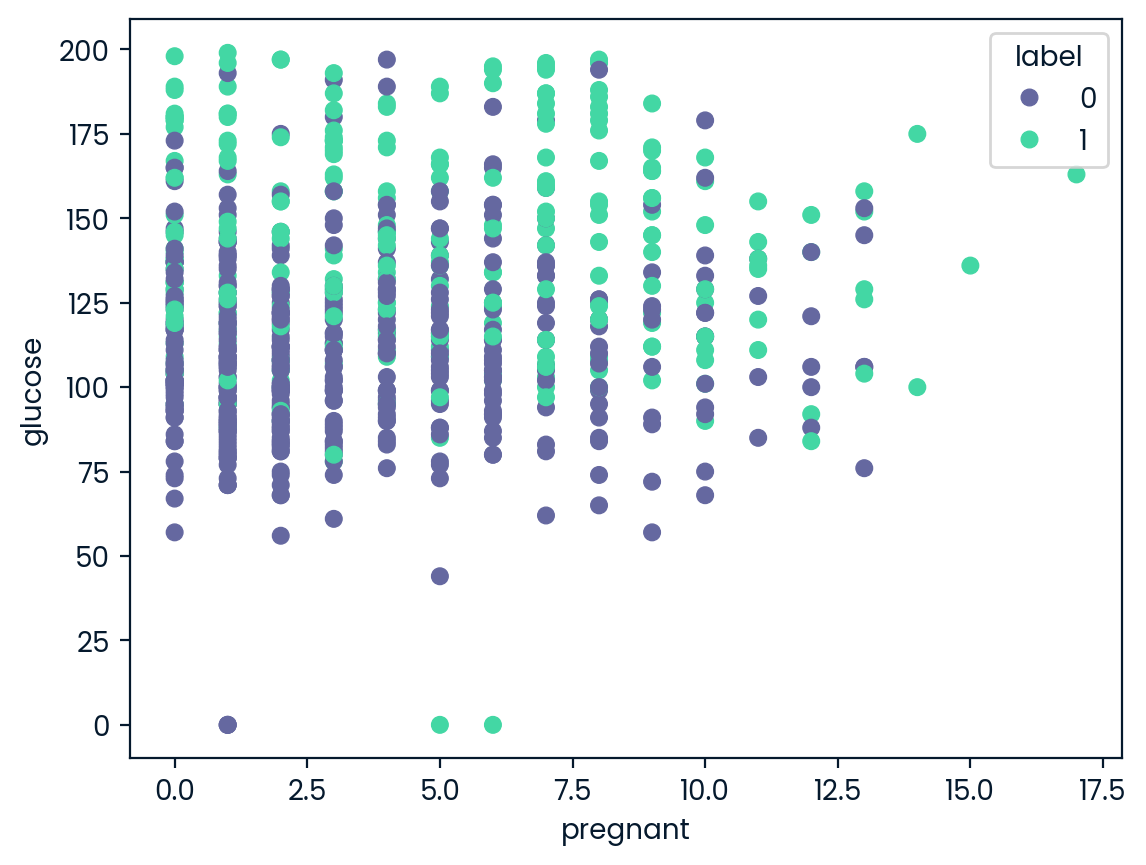

[8.88546635e-01 6.15907837e-02 2.57901189e-02 1.30861374e-02
 7.44093864e-03 3.02614919e-03 5.12444875e-04 6.79264301e-06]


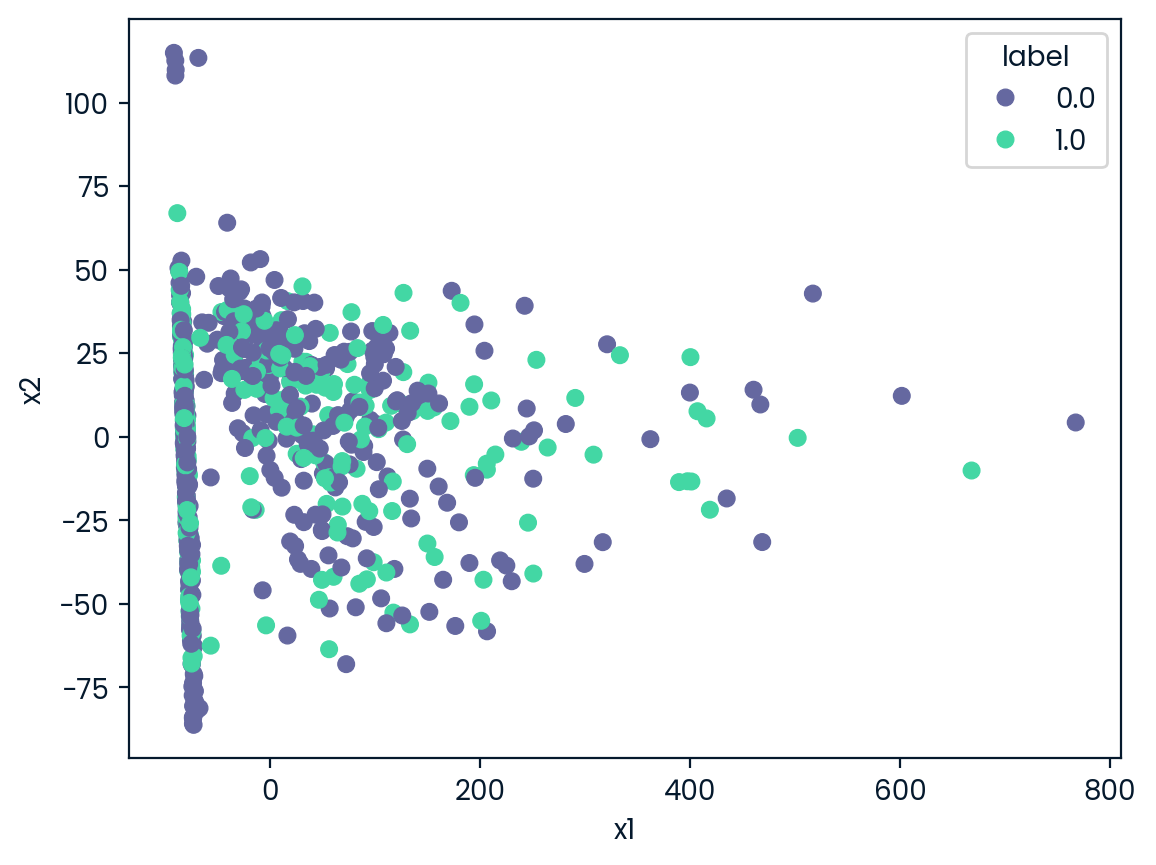

In [53]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

#pima['pregnant'] = pima['pregnant'].apply(lambda x: 0 if x == 0 else 1)
pima_plot = pd.concat([pima.iloc[:,:2], pima.iloc[:,-1]], axis=1)

sns.scatterplot(x='pregnant', y='glucose', data=pima_plot, hue='label', ec=None)
plt.show()

# Split data into features and label 
X = pima.iloc[:,:-1].copy()
y = pd.DataFrame(pima.iloc[:,-1].copy())

# Feature importance
pca = PCA()
pca.fit(X)
print(pca.explained_variance_ratio_)

# Instantiate scaler and fit on features
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X.values)

# Feature transformation
pca = PCA(n_components=2)
pca_plot = pd.concat([pd.DataFrame(pca.fit_transform(X), columns=['x1', 'x2']), y], axis=1)

sns.scatterplot(x='x1', y='x2', data=pca_plot, hue='label', ec=None)
plt.show()


# Model training

### Training and test sets

In [54]:
from sklearn.model_selection import train_test_split

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=.8, stratify=y, random_state=25)

# Check the splits are correct
print(f"Train size: {round(len(X_train) / len(X) * 100)}% \n\
Test size: {round(len(X_test) / len(X) * 100)}%")
print(y_test.value_counts(), y_train.value_counts())

Train size: 80% 
Test size: 20%
label
0        100
1         54
dtype: int64 label
0        400
1        214
dtype: int64


## Model building

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Instnatiating the models 
models = {'LogisticRegression': LogisticRegression(), 'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=5)}

preds = {}

# Training the models 
for name, model in models.items():
    model.fit(X_train, y_train)
    preds[name] = [model.predict(X_test), model.score(X_test, y_test), model.predict_proba(X_test)]
    
print(f'Stored {len(preds)} models')

Stored 2 models


# Model evaluation 

In [56]:
#Basic metrics
from sklearn.metrics import confusion_matrix, classification_report

for model, values in preds.items():  
    print(f"{model} score: {values[1]}", sep="\n\n")
    print(classification_report(y_test, values[0], target_names=['0', '1']))


LogisticRegression score: 0.7857142857142857
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       100
           1       0.72      0.63      0.67        54

    accuracy                           0.79       154
   macro avg       0.77      0.75      0.76       154
weighted avg       0.78      0.79      0.78       154

KNeighborsClassifier score: 0.7597402597402597
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       100
           1       0.67      0.61      0.64        54

    accuracy                           0.76       154
   macro avg       0.74      0.73      0.73       154
weighted avg       0.76      0.76      0.76       154



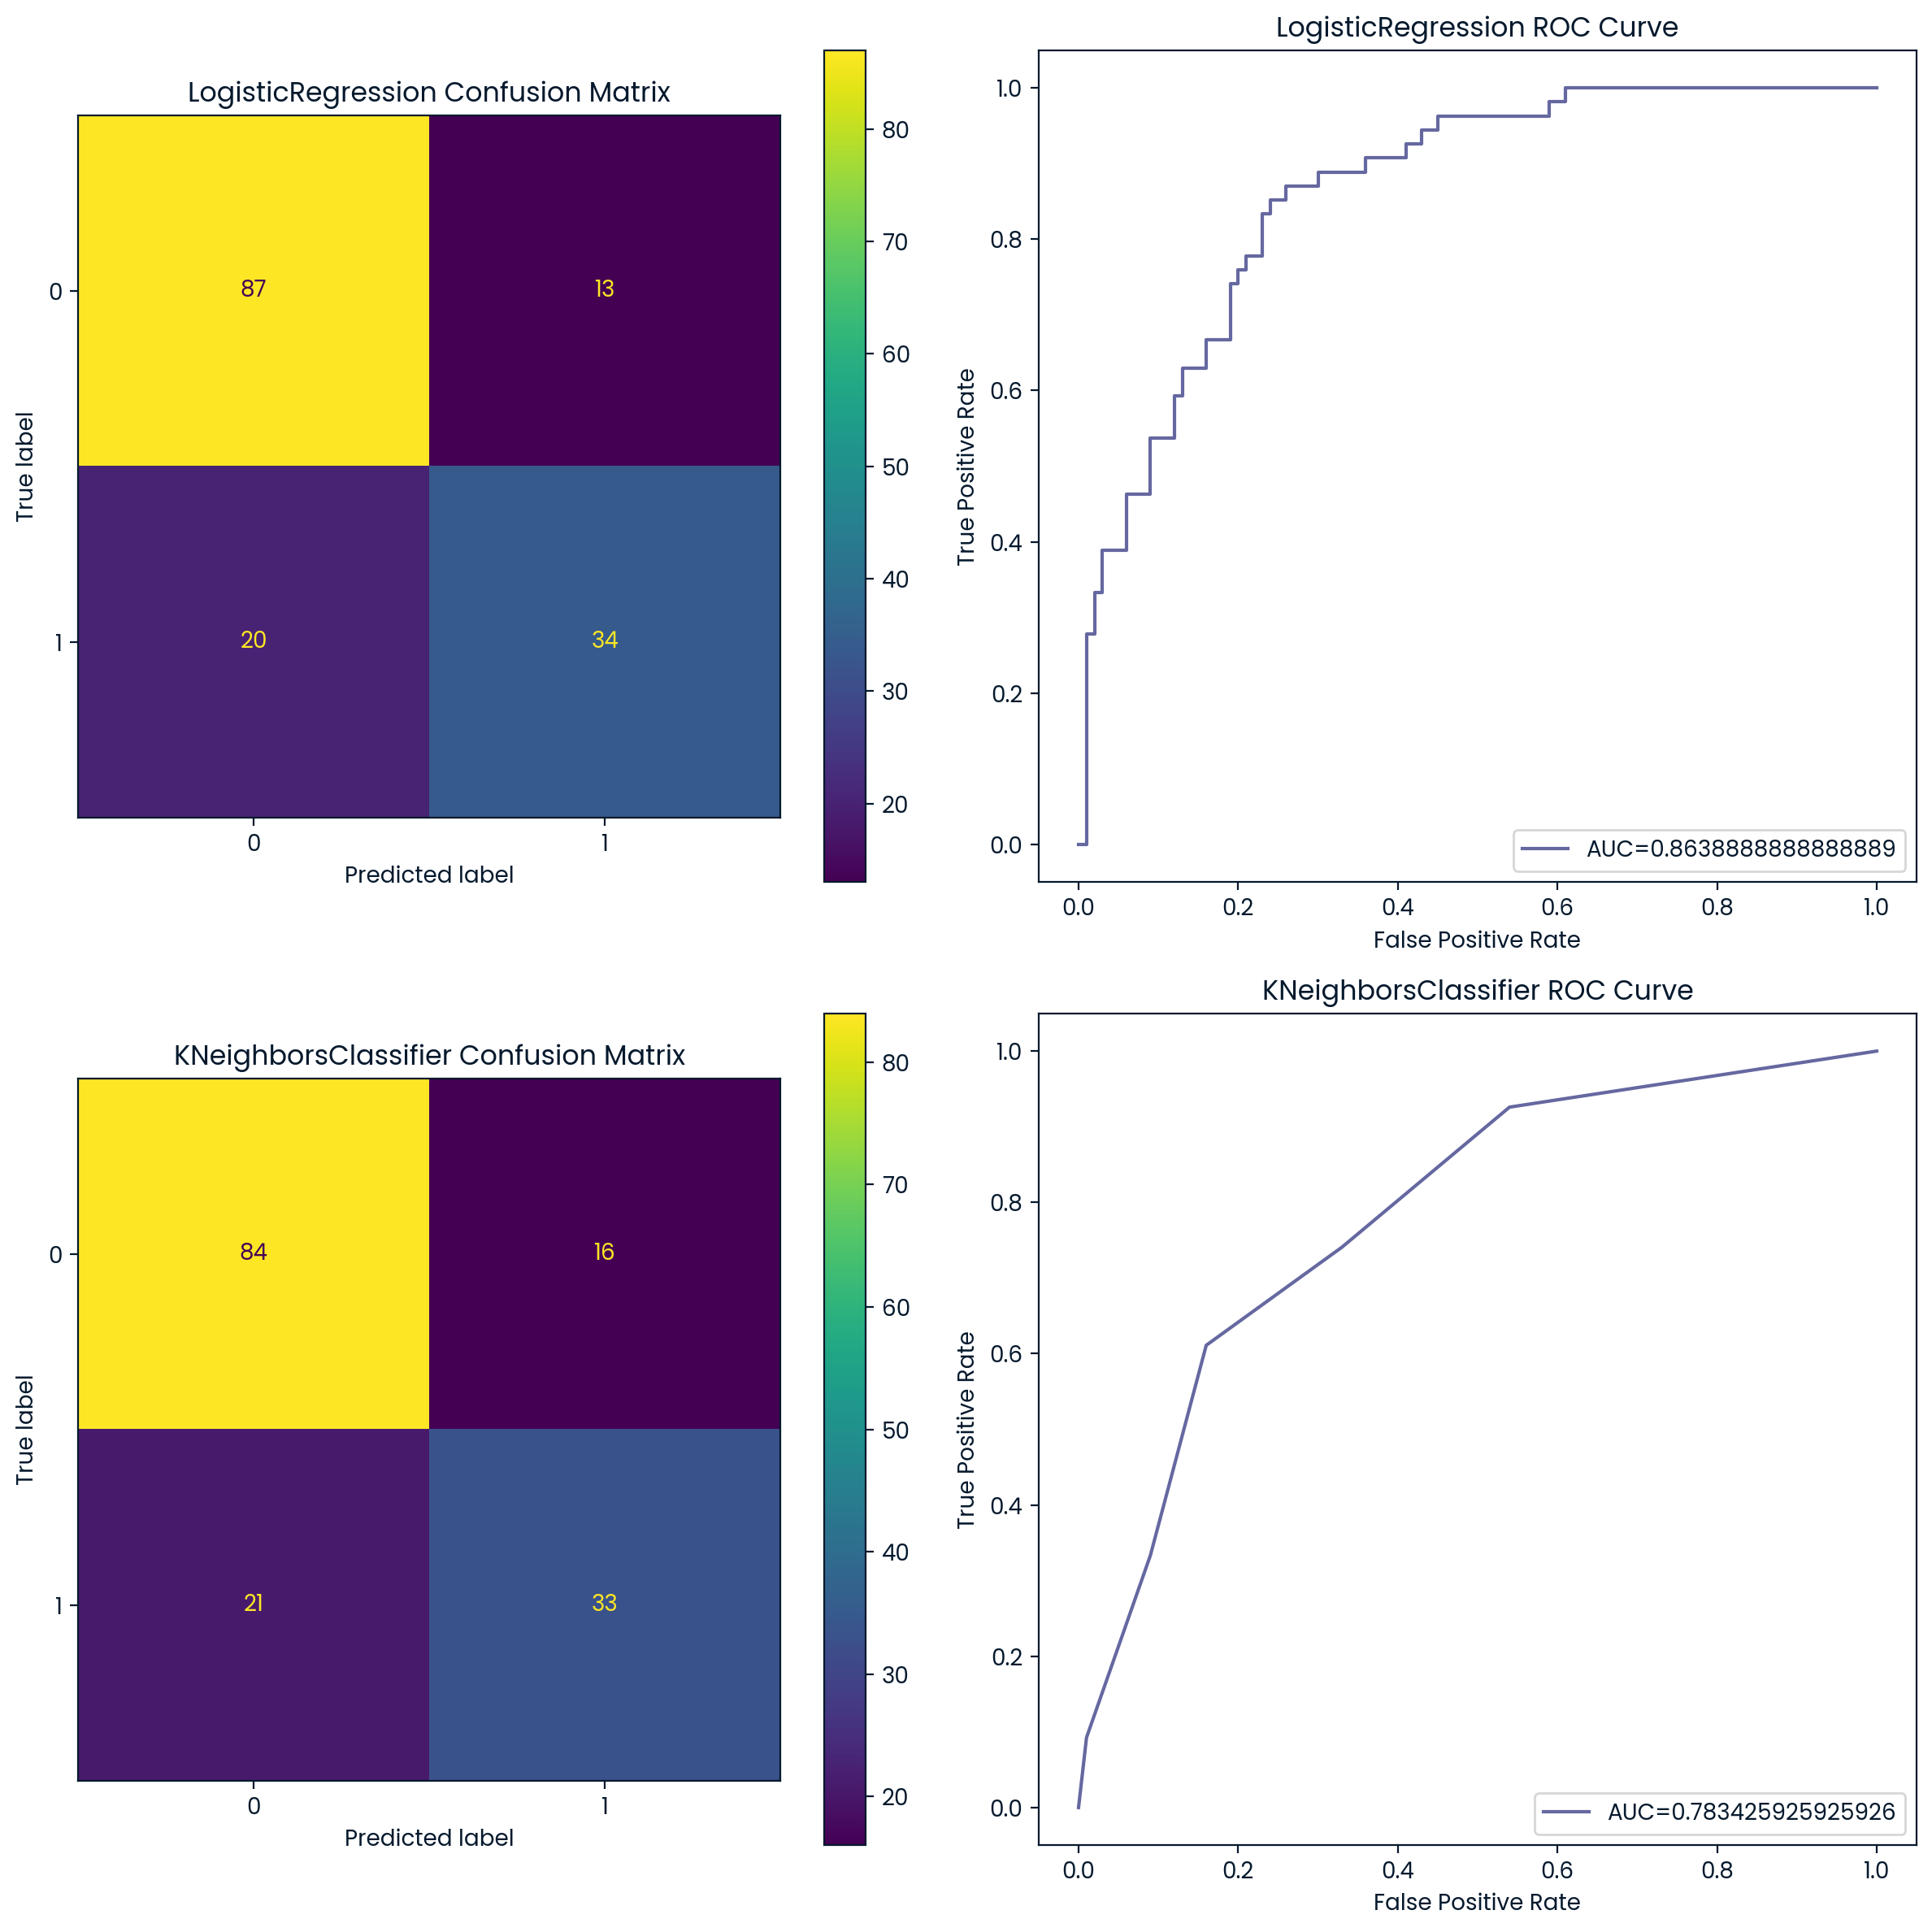

In [57]:
# Display metrics side by side
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(preds), 2, figsize=(12, 6 * len(preds)))

for idx, (model, values) in enumerate(preds.items()):
    # Confusion Matrix
    cm = confusion_matrix(y_test, values[0])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(ax=axes[idx, 0])
    axes[idx, 0].set_title(f'{model} Confusion Matrix')
    
    # ROC Curve
    fpr, tpr, threshold = roc_curve(y_test, values[2][:, 1])
    auc = roc_auc_score(y_test, values[2][:, 1])
    axes[idx, 1].plot(fpr, tpr, label="AUC="+str(auc))
    axes[idx, 1].legend(loc=4)
    axes[idx, 1].set_title(f'{model} ROC Curve')
    axes[idx, 1].set_ylabel('True Positive Rate')
    axes[idx, 1].set_xlabel('False Positive Rate')

plt.tight_layout()
plt.show()